In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
%matplotlib inline

In [8]:
# departements and aisle id
aisles = pd.read_csv('aisles.csv')
departements = pd.read_csv('departments.csv')
products = pd.read_csv('products.csv')
product_mapping = products[['product_id','product_name']].set_index('product_id').to_dict()['product_name']
print(aisles.head(3))
print(departements.head(3))
print(products.head(3))

   aisle_id                  aisle
0         1  prepared soups salads
1         2      specialty cheeses
2         3    energy granola bars
   department_id department
0              1     frozen
1              2      other
2              3     bakery
   product_id                          product_name  aisle_id  department_id
0           1            Chocolate Sandwich Cookies        61             19
1           2                      All-Seasons Salt       104             13
2           3  Robust Golden Unsweetened Oolong Tea        94              7


In [10]:
# Products purchased in each order. 
# Order_products__prior.csv : contains previous order contents for all customers. 
# 'reordered' customer has a previous order with this product
order_products = pd.read_csv('order_products__prior.csv')
order_products.head(3)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0


In [11]:
# Order with sets (prior, train, test). 
# You are predicting reordered items only for the test set orders. 
# 'order_dow' is the day of week
orders = pd.read_csv('orders.csv')
orders.sample(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
1413022,2614020,84896,prior,34,5,15,2.0
960958,482630,57695,prior,4,3,11,30.0
232879,1336307,14120,prior,33,4,13,5.0


In [16]:
print("Unique products: {}".format(len(products.product_id.unique())))

Unique products: 49688


In [17]:

print("Unique users: {}".format(len(orders.user_id.unique())))

Unique users: 206209


In [20]:
print(orders.shape)

(3421083, 7)


In [21]:
# The dataset contains 3421083 orders from 206209 different users. 49688 different products have been purchased.

In [24]:
orders[orders.user_id == 1]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


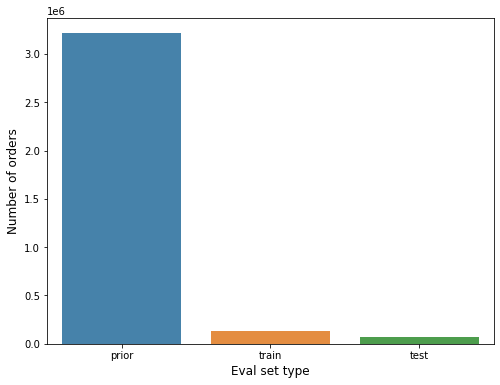

In [26]:
eval_cnt = orders.eval_set.value_counts()

plt.figure(figsize=(8,6))
sns.barplot(eval_cnt.index, eval_cnt.values, alpha = 0.9)
plt.ylabel('Number of orders', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.show()

In [29]:
orders.groupby("eval_set")["user_id"].unique().apply(len)

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

Text(0.5, 0, 'Counts')

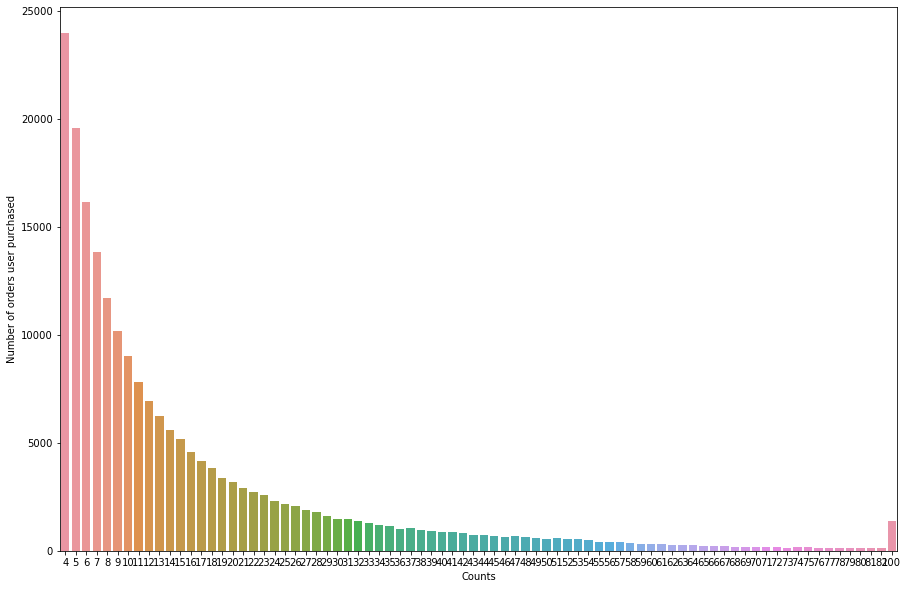

In [30]:
# How many orders does every person have beforehand
#order history length
order_length_cnt = orders.groupby("user_id")["order_number"].aggregate(max).value_counts()
cut_off = 80
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(order_length_cnt.index[:cut_off], order_length_cnt.values[:cut_off])
plt.ylabel('Number of orders user purchased')
plt.xlabel('Counts')

In [32]:
print("Average number of orders for users:{}".format(orders.groupby("user_id")["order_number"].aggregate(max).mean()))

Average number of orders for users:16.590367054784224


Text(0.5, 0, 'Number of products in one order')

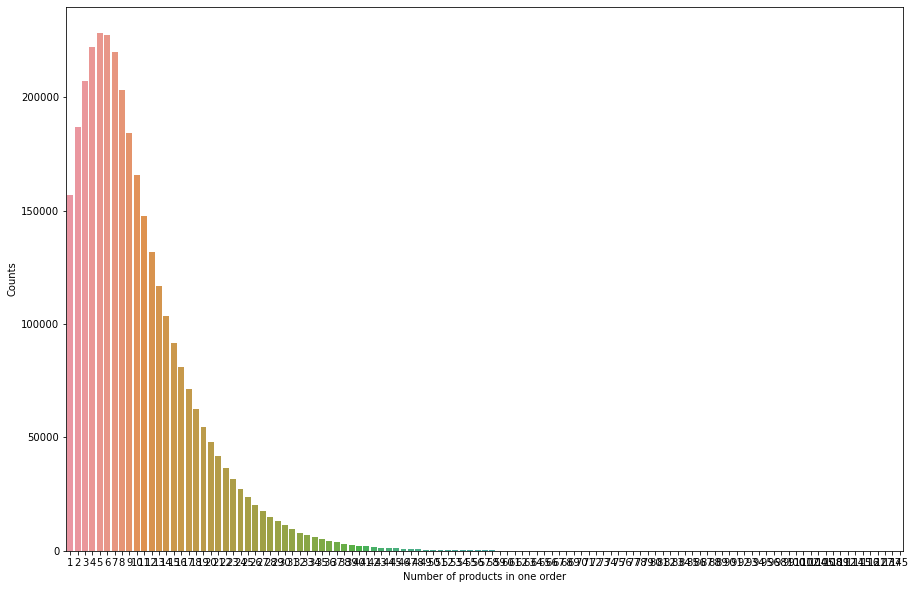

In [35]:
# How many products each order contains?


#basket size histogram
basket_size_cnt = order_products.groupby("order_id")["add_to_cart_order"].aggregate(max).value_counts()

f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(basket_size_cnt.index, basket_size_cnt.values)
plt.ylabel('Counts')
plt.xlabel('Number of products in one order')

In [36]:
print("Average basket size:{}".format(order_products.groupby("order_id")["add_to_cart_order"].aggregate(max).mean()))


Average basket size:10.088883421247614


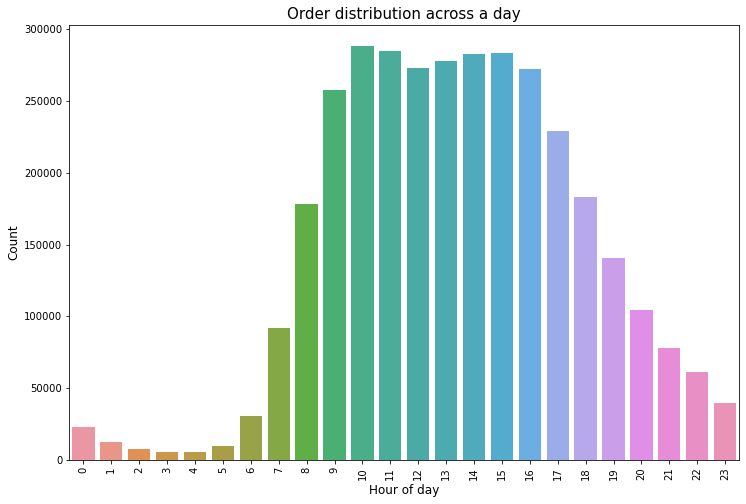

In [39]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Order distribution across a day", fontsize=15)
plt.show()

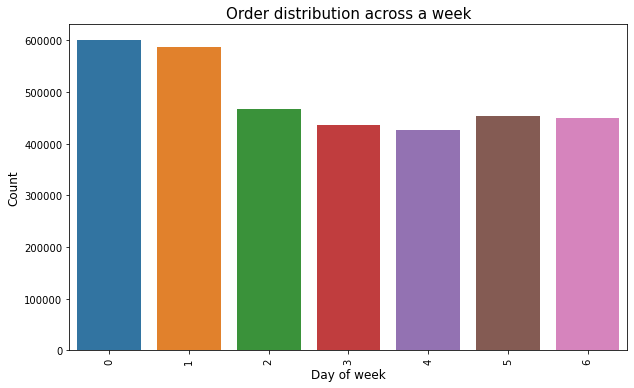

In [43]:
plt.figure(figsize=(10,6))
sns.countplot(x="order_dow", data=orders)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Order distribution across a week", fontsize=15)
plt.show()

In [45]:
df_order_products_train = pd.merge(order_products, orders, on='order_id', how='left')
grouped_df = df_order_products_train.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df.head()

,order_dow,order_hour_of_day,reordered
0,0,0,0.576500
1,0,1,0.551792
2,0,2,0.552299
3,0,3,0.569427
4,0,4,0.546584


In [46]:
grouped_df = grouped_df.pivot(index='order_dow', columns = 'order_hour_of_day', values = 'reordered')
grouped_df.head()

order_hour_of_day,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
order_dow,,,,,,,,,,,,,,,,,,,,,
0,0.576500,0.551792,0.552299,0.569427,0.546584,0.593242,0.622488,0.639452,0.626547,0.607529,...,0.575292,0.578199,0.575274,0.570007,0.572861,0.581956,0.595262,0.607195,0.598639,0.598127
1,0.588969,0.593080,0.558103,0.573517,0.596377,0.626057,0.659062,0.671571,0.661973,0.651143,...,0.589955,0.583087,0.579219,0.579604,0.573547,0.570348,0.577493,0.581970,0.577404,0.577420
2,0.564385,0.558086,0.563857,0.578850,0.562776,0.611107,0.640177,0.642603,0.632893,0.621903,...,0.582838,0.579452,0.582815,0.572966,0.573171,0.573782,0.566664,0.580164,0.571384,0.574567
3,0.552116,0.536828,0.539695,0.549420,0.553363,0.604140,0.631227,0.642687,0.621007,0.612894,...,0.573512,0.580905,0.577994,0.578211,0.575737,0.575770,0.578691,0.581080,0.584147,0.569541
4,0.557992,0.538137,0.545808,0.559874,0.582984,0.604880,0.638653,0.636844,0.623302,0.608692,...,0.584057,0.585931,0.584787,0.586410,0.583329,0.581323,0.592181,0.595131,0.583407,0.570399


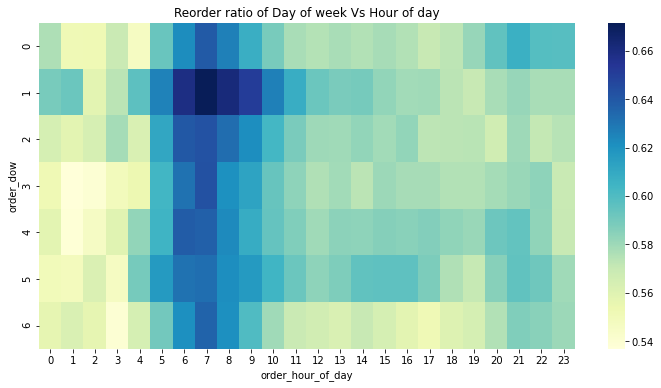

In [47]:
plt.figure(figsize=(12,6))
sns.heatmap(grouped_df, cmap="YlGnBu")
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()

In [48]:
aisles.isnull().sum()
departements.isnull().sum()
products.isnull().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

In [1]:
# Add to Cart - Reorder ratio:
order_products_prior['add_to_cart_order_mod'] = order_products_prior['add_to_cart_order'].copy()
order_products_prior['add_to_cart_order_mod'].iloc[order_products_prior['add_to_cart_order_mod']>60] = 60
grouped_df = order_products_prior.groupby(['add_to_cart_order_mod'])['reordered'].aggregate('mean').reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8, color=color[0])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

NameError: name 'order_products_prior' is not defined